In [83]:
codigo_acao_pesquisada = "EZTC3"

Indicadores capturados:   
* **'papel'**:  Ticker da ação (EZTC3, PETR4, etc)
* **'cotacao'**: Preço da cotação
* **'tipo'**: Tipo do papel (ON, PN, etc)
* **'data_ult_cot'**:
* **'empresa'**: Nome da empresa
* **'min_52_sem'**: Mínima das últimas 52 semanas
* **'setor'**: Setor da empresa
* **'max_52_sem'**: Máxima das últimas 52 semanas
* **'subsetor'**: Subsetor da empresa
* **'vol__med_2m'**: Volume médio diário negociados nos últimos 2 meses
* **'valor_de_mercado'**: Valor de mercado da ação
* **'ult_balanco_processado'**:
* **'valor_da_firma'**: Valor da firma
* **'nro_acoes'**: Número de ações
* **'dia'**:
* **'pl'**: Indicador Preço / Lucro
* **'lpa'**: Indicador Lucro por ação
* **'mes'**:
* **'pvp'**: Indicador Preço sobre valor patrimonial
* **'vpa'**: Indicador Valor patrimonial por ação
* **'30_dias'**:
* **'pebit'**: Indicador Preço / EBIT
* **'marg_bruta'**: Indicador margem bruta (porcentagem)
* **'12_meses'**:
* **'psr'**:
* **'marg_ebit'**:
* **'2023'**:
* **'pativos'**:
* **'marg_liquida'**,
* **'2022'**:
* **'pcap_giro'**:
* **'ebit__ativo'**:
* **'2021'**:
* **'pativ_circ_liq'**:
* **'roic'**,
* **'2020'**:
* **'div_yield'**:
* **'roe'**:
* **'2019'**:
* **'ev__ebitda'**:
* **'liquidez_corr'**,
* **'2018'**:
* **'ev__ebit'**:
* **'div_br_patrim'**:
* **'cres_rec_5a'**:
* **'giro_ativos'**,
* **'ativo'**:
* **'div_bruta'**:
* **'disponibilidades'**:
* **'div_liquida'**,
* **'ativo_circulante'**:
* **'patrim_liq'**:
* **'receita_liquida'**,
* **'receita_liquida_3meses'**:
* **'ebit'**:
* **'ebit_3meses'**:
* **'lucro_liquido'**,
* **'lucro_liquido_3meses'**:
* **'valor_intrinsico'**:
* **'pct_intrinsica_da_cotacao'**,
* **'desconto_intrinsico'**:  

Esta variável define quais multiplos serão usados para rankear as empresas do setor  

False significa que a ordenação será em ordem do maior para o menor.
True é do menor para o maior

In [84]:
multiplo_ordenacao = {
    "patrim_liq": False,
    "vol__med_2m": False,
    "roe": False,
    "roic": False,
    "cres_rec_5a": False,
    "marg_ebit": False,
    "marg_liquida": False,
    "div_br_patrim": True,
    "liquidez_corr": False,
    "div_yield": False
}

## Imports

In [85]:
import re

from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
from urllib.error import URLError, HTTPError

import pandas as pd

import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Funções

In [86]:
def convenciona_nome(nome):

  # remove espaços e deixa minúsculo
  nome = nome.strip()
  nome = nome.replace(" ", "_")
  nome = nome.lower()

  # substitui caracteres de acentos pelos seus sem acento
  nome = nome.replace("ç", "c")
  nome = nome.replace("ñ", "n")
  nome = re.sub(r"[áàâã]","a", nome)
  nome = re.sub(r"[éèê]","e", nome)
  nome = re.sub(r"[íî]","i", nome)
  nome = re.sub(r"[óòôõ]","o", nome)
  nome = re.sub(r"[úùû]","u", nome)

  # mantem só letras e números
  nome = re.sub(r"[^a-zA-Z0-9_]","", nome)

  return str(nome)

In [87]:
def padroniza_valor(valor_original):
  # remove espaços e deixa minúsculo
  valor = valor_original.strip()
  valor = valor.lower()

  # vê se estamos com um valor numérico
  valor = valor.replace(".", "#")
  valor = valor.replace(",", ".")
  valor = valor.replace("#", "")
  valor_numerico = valor.replace("%", "")

  if valor_numerico.replace(".", "").replace("-","").isnumeric():
    return float(valor_numerico)
  else:
    return valor_original.strip()

## Encontra o setor de determinada ação

In [88]:
site= "https://www.fundamentus.com.br/detalhes.php?papel=" + codigo_acao_pesquisada
hdr = {'User-Agent': 'Mozilla/5.0'}
req = Request(site,headers=hdr)
page = urlopen(req)
soup = BeautifulSoup(page)

In [89]:
numero_do_setor = ""

for a in soup.findAll("a"):
  if "href" in a.attrs:
    if str(a["href"]).startswith("resultado.php?setor"):
      print(a["href"])
      numero_do_setor = str(a["href"]).split("=")[1]

resultado.php?setor=10


## Pega lista de ações do setor

In [90]:
# Energia elétrica -> setor=14

site= "https://www.fundamentus.com.br/resultado.php?setor=" + numero_do_setor
hdr = {'User-Agent': 'Mozilla/5.0'}
req = Request(site,headers=hdr)
page = urlopen(req)
soup_lista = BeautifulSoup(page)

soup_lista

linhas = soup_lista.findAll("tr")

del linhas[0]

acao_liquidez = {}

for linha in linhas:
  dados = {}

  ticker = linha.findAll("td")[0].getText()
  dados["ticker"] = ticker

  liquidez = padroniza_valor(linha.findAll("td")[17].getText())
  dados["liquidez"] = liquidez

  empresa = linha.findAll("td")[0].find("span").attrs["title"]
  dados["empresa"] = empresa

  acao_liquidez[ticker] = dados

df_acaoLiquidez = pd.DataFrame(acao_liquidez).T

# exclui as ações de mesmas empresas que possuem menores volumes financeiros
lista_empresas = df_acaoLiquidez['empresa'].unique()

tabela_nova = pd.DataFrame()
lista_acoes_maior_volume = []

for i in lista_empresas:
  selecao = df_acaoLiquidez['empresa']==i
  linha = df_acaoLiquidez[selecao]
  maior_volume = max(linha['liquidez'])
  selecao = linha['liquidez']==max(linha['liquidez'])
  lista_acoes_maior_volume.append(linha[selecao].index[0])

lista_acoes_maior_volume

['MRVE3',
 'GFSA3',
 'VIVR3',
 'TEND3',
 'JFEN3',
 'AVLL3',
 'PDGR3',
 'RSID3',
 'CALI3',
 'CRDE3',
 'JHSF3',
 'MDNE3',
 'EVEN3',
 'CYRE3',
 'HBOR3',
 'MELK3',
 'LAVV3',
 'DIRR3',
 'TRIS3',
 'CURY3',
 'PLPL3',
 'RDNI3',
 'EZTC3',
 'MTRE3',
 'TCSA3']

## Captura os dados das ações listadas

In [91]:
acoes = lista_acoes_maior_volume

dados_acao = {}

for acao in acoes:

  site= "https://www.fundamentus.com.br/detalhes.php?papel=" + acao
  hdr = {'User-Agent': 'Mozilla/5.0'}
  req = Request(site,headers=hdr)
  page = urlopen(req)
  soup = BeautifulSoup(page)

  chaves = soup.findAll("td", {"class":"label"})
  valores = soup.findAll("td", {"class":"data"})

  dados = {}

  for chave, valor in tuple(zip(chaves, valores)):
    chave_alt = chave.find("span", {"class":"txt"}).getText()
    chave_alt = convenciona_nome(chave_alt)

    if chave_alt is not "":
      # print(chave_alt)
      try:
        valor_alt = valor.find("span", {"class":"txt"}).getText()
      except:
        try:
          valor_alt = valor.find("font").getText()
        except:
          pass
      valor_alt = padroniza_valor(valor_alt)
      # print(valor_alt)
      # print(type(valor_alt))
      if chave_alt in dados:
        dados[chave_alt + "_3meses"] = valor_alt
      else:
        dados[chave_alt] = valor_alt
    # print("--------")
    dados_acao[acao] = dados

<>:22: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:22: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-91-506fc972b563>:22: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if chave_alt is not "":


In [92]:
tabelao = pd.DataFrame(dados_acao).T
tabelao

,papel,cotacao,tipo,data_ult_cot,empresa,min_52_sem,setor,max_52_sem,subsetor,vol__med_2m,...,disponibilidades,div_liquida,ativo_circulante,patrim_liq,receita_liquida,receita_liquida_3meses,ebit,ebit_3meses,lucro_liquido,lucro_liquido_3meses
MRVE3,MRVE3,10.43,ON NM,27/06/2023,MRV ON NM,5.53,Construção Civil,12.93,Incorporações,123495000.0,...,988881000.0,6772500000.0,10052000000.0,5848710000.0,6647870000.0,1689890000.0,41320100.0,44344000.0,-243235000.0,30577000.0
GFSA3,GFSA3,6.97,ON,27/06/2023,GAFISA ON,4.94,Construção Civil,30.7,Incorporações,31779800.0,...,425058000.0,1484530000.0,3780720000.0,1782470000.0,1233200000.0,292506000.0,-57966000.0,-13453000.0,-117311000.0,-34022000.0
VIVR3,VIVR3,3.19,ON NM,27/06/2023,VIVER ON NM,3.07,Construção Civil,8.1,Incorporações,2550740.0,...,40498000.0,-2614000.0,188475000.0,33313000.0,126690000.0,18363000.0,-7944000.0,-9531000.0,-31086000.0,-26197000.0
TEND3,TEND3,9.48,ON NM,27/06/2023,Tenda ON NM,3.79,Construção Civil,9.59,Incorporações,29172400.0,...,603643000.0,757530000.0,1784700000.0,673130000.0,2482620000.0,651443000.0,-120461000.0,47483000.0,-521863000.0,-41902000.0
JFEN3,JFEN3,2.88,ON,27/06/2023,JOÃO FORTES ENGENHARIA S.A. ON,2.27,Construção Civil,5.0,Incorporações,94601.0,...,13390000.0,599250000.0,955137000.0,-642034000.0,42974000.0,42384000.0,-57171000.0,-7233000.0,-44565000.0,40111000.0
AVLL3,AVLL3,7.24,ON NM,27/06/2023,ALPHAVILLE ON NM,2.4,Construção Civil,23.0,Incorporações,87462.0,...,148472000.0,914061000.0,672625000.0,-452569000.0,332992000.0,95136000.0,-43265000.0,8991000.0,-382944000.0,-57620000.0
PDGR3,PDGR3,5.95,ON NM,27/06/2023,PDG REALT ON NM,3.13,Construção Civil,107.0,Incorporações,1330610.0,...,90939000.0,1242160000.0,893842000.0,-5025040000.0,117554000.0,6052000.0,-68621000.0,-27775000.0,-333792000.0,-208970000.0
RSID3,RSID3,4.76,ON N1,27/06/2023,ROSSI RESIDENCIAL ON N1,2.17,Construção Civil,5.18,Incorporações,297339.0,...,8415000.0,605895000.0,371452000.0,-1156950000.0,0.0,-27319000.0,0.0,-16703000.0,0.0,-48847000.0
CALI3,CALI3,13.5,ON,23/06/2023,CAL S/A ON,5.82,Construção Civil,14.74,Incorporações,1374.0,...,22745000.0,58074000.0,98069000.0,27760000.0,165862000.0,34922000.0,14839000.0,2885000.0,12557000.0,4109000.0
CRDE3,CRDE3,16.0,ON,14/06/2023,CR2 ON,10.58,Construção Civil,21.57,Incorporações,13080.0,...,6588000.0,-6588000.0,13665000.0,90837000.0,4048000.0,112000.0,-8437000.0,-1933000.0,7960000.0,-1905000.0


## Manipula a tabela
- muda os tipos das colunas
- calcula valor intrínsico
- filtra tabela

In [93]:
colunas_excecoes = ['roe', 'roic', 'ev__ebitda', 'pebit', 'marg_bruta', 'psr', 'marg_ebit', 'marg_liquida', 'ev__ebit', 'div_br_patrim']

# atribui o tipo float nas colunas
for cabecalho in tabelao:
  try:
    tabelao[cabecalho] = tabelao[cabecalho].astype(float)
  except:
    tabelao[cabecalho] = tabelao[cabecalho].astype(str)

for cabecalho in colunas_excecoes:
  tabelao[cabecalho] = pd.to_numeric(tabelao[cabecalho], errors='coerce').fillna(0).astype(float)

# calcula o valor intrinsico
tabelao["valor_intrinsico"] = round((tabelao["vpa"] * tabelao["lpa"] * 22.5)**(1/2), 2)
tabelao["pct_intrinsica_da_cotacao"] = round((tabelao["cotacao"] / tabelao["valor_intrinsico"]) * 100, 2)
tabelao["desconto_intrinsico"] = round(((tabelao["cotacao"] / tabelao["valor_intrinsico"]) - 1) * 100, 2)

In [94]:
# Filtros
# selecao = tabelao["vol__med_2m"] > 1000000
# tabelao = tabelao[selecao]
# selecao = tabelao["pl"] > 0
# tabelao = tabelao[selecao]

## Ranks

In [95]:
dict_ranks = {}

for acao in tabelao.index:
  dict_ranks[acao]= {}

  for multiplo, ordenacao in multiplo_ordenacao.items():
    rank = tabelao.sort_values(by = multiplo, ascending=ordenacao).index.get_loc(tabelao[tabelao["papel"] == acao].index[0]) + 1
    dict_ranks[acao][multiplo] = rank

In [96]:
ranks_todas_acoes = pd.DataFrame(dict_ranks).T
ranks_todas_acoes

,patrim_liq,vol__med_2m,roe,roic,cres_rec_5a,marg_ebit,marg_liquida,div_br_patrim,liquidez_corr,div_yield
MRVE3,2,1,22,16,19,16,19,23,17,12
GFSA3,6,5,23,18,11,18,20,17,16,16
VIVR3,20,15,25,19,17,20,22,21,20,24
TEND3,15,6,24,22,15,19,21,24,21,23
JFEN3,23,21,12,23,24,24,23,2,22,22
AVLL3,22,22,1,20,13,21,24,1,23,21
PDGR3,25,17,14,25,22,23,25,4,25,20
RSID3,24,20,21,17,23,17,18,3,24,19
CALI3,21,25,2,3,1,11,14,25,18,6
CRDE3,19,24,10,24,25,25,1,5,2,18


### Ranking da ação pedida

In [97]:
ranks_todas_acoes.loc[[codigo_acao_pesquisada]].T

,EZTC3
patrim_liq,4
vol__med_2m,3
roe,16
roic,13
cres_rec_5a,10
marg_ebit,9
marg_liquida,3
div_br_patrim,8
liquidez_corr,1
div_yield,15


### Ranking de cada múltiplo

In [98]:
for multiplo, ordenacao in multiplo_ordenacao.items():
  display(tabelao.sort_values(by = multiplo, ascending=ordenacao)[[multiplo]])
  print("------")

,patrim_liq
CYRE3,7.222280e+09
MRVE3,5.848710e+09
JHSF3,4.988590e+09
EZTC3,4.511870e+09
EVEN3,1.961160e+09
GFSA3,1.782470e+09
HBOR3,1.378720e+09
DIRR3,1.350290e+09
TRIS3,1.289270e+09
MELK3,1.228400e+09


------


,vol__med_2m
MRVE3,123495000.0
CYRE3,115616000.0
EZTC3,45124000.0
DIRR3,38958200.0
GFSA3,31779800.0
TEND3,29172400.0
CURY3,26964700.0
JHSF3,16115400.0
PLPL3,8066860.0
EVEN3,6683900.0


------


,roe
AVLL3,84.6
CALI3,45.2
CURY3,42.7
PLPL3,33.8
DIRR3,17.8
CYRE3,11.2
JHSF3,10.7
LAVV3,10.3
MDNE3,9.4
CRDE3,8.8


------


,roic
PLPL3,32.1
CURY3,27.5
CALI3,8.2
DIRR3,8.1
JHSF3,7.2
LAVV3,6.7
MDNE3,5.0
CYRE3,4.9
MELK3,4.4
EVEN3,4.1


------


,cres_rec_5a
CALI3,142.3
JHSF3,43.3
CURY3,38.3
MTRE3,37.6
MELK3,35.3
RDNI3,33.0
MDNE3,26.8
PLPL3,24.2
LAVV3,22.8
EZTC3,21.2


------


,marg_ebit
JHSF3,38.5
PLPL3,24.7
CURY3,21.5
DIRR3,19.2
LAVV3,15.6
MDNE3,14.7
CYRE3,12.0
TRIS3,11.1
EZTC3,9.8
EVEN3,9.4


------


,marg_liquida
CRDE3,195.6
JHSF3,30.8
EZTC3,25.6
LAVV3,21.9
CYRE3,16.1
CURY3,15.8
DIRR3,13.4
MDNE3,12.7
HBOR3,11.3
TRIS3,10.7


------


,div_br_patrim
AVLL3,-2.35
JFEN3,-0.95
RSID3,-0.53
PDGR3,-0.27
CRDE3,0.00
LAVV3,0.04
MDNE3,0.12
EZTC3,0.13
MELK3,0.15
EVEN3,0.41


------


,liquidez_corr
EZTC3,5.48
CRDE3,5.02
LAVV3,4.59
MELK3,3.86
JHSF3,3.78
TCSA3,3.75
TRIS3,3.71
DIRR3,3.43
HBOR3,3.14
PLPL3,3.06


------


,div_yield
MELK3,9.1
LAVV3,7.9
JHSF3,6.9
DIRR3,6.5
MTRE3,6.4
CALI3,3.3
CYRE3,2.7
HBOR3,2.7
TRIS3,2.5
EVEN3,2.4


------


### Ranking de múltiplo específico

In [99]:
tabelao.sort_values(by = "roe", ascending=False)[["roe"]]

,roe
AVLL3,84.6
CALI3,45.2
CURY3,42.7
PLPL3,33.8
DIRR3,17.8
CYRE3,11.2
JHSF3,10.7
LAVV3,10.3
MDNE3,9.4
CRDE3,8.8


## Cria a pasta para salvar cada gráfico

In [100]:
if os.path.exists('/content/graficos') == False:
  os.mkdir('/content/graficos')

## Printa todos os gráficos pedidos em barras horizontais

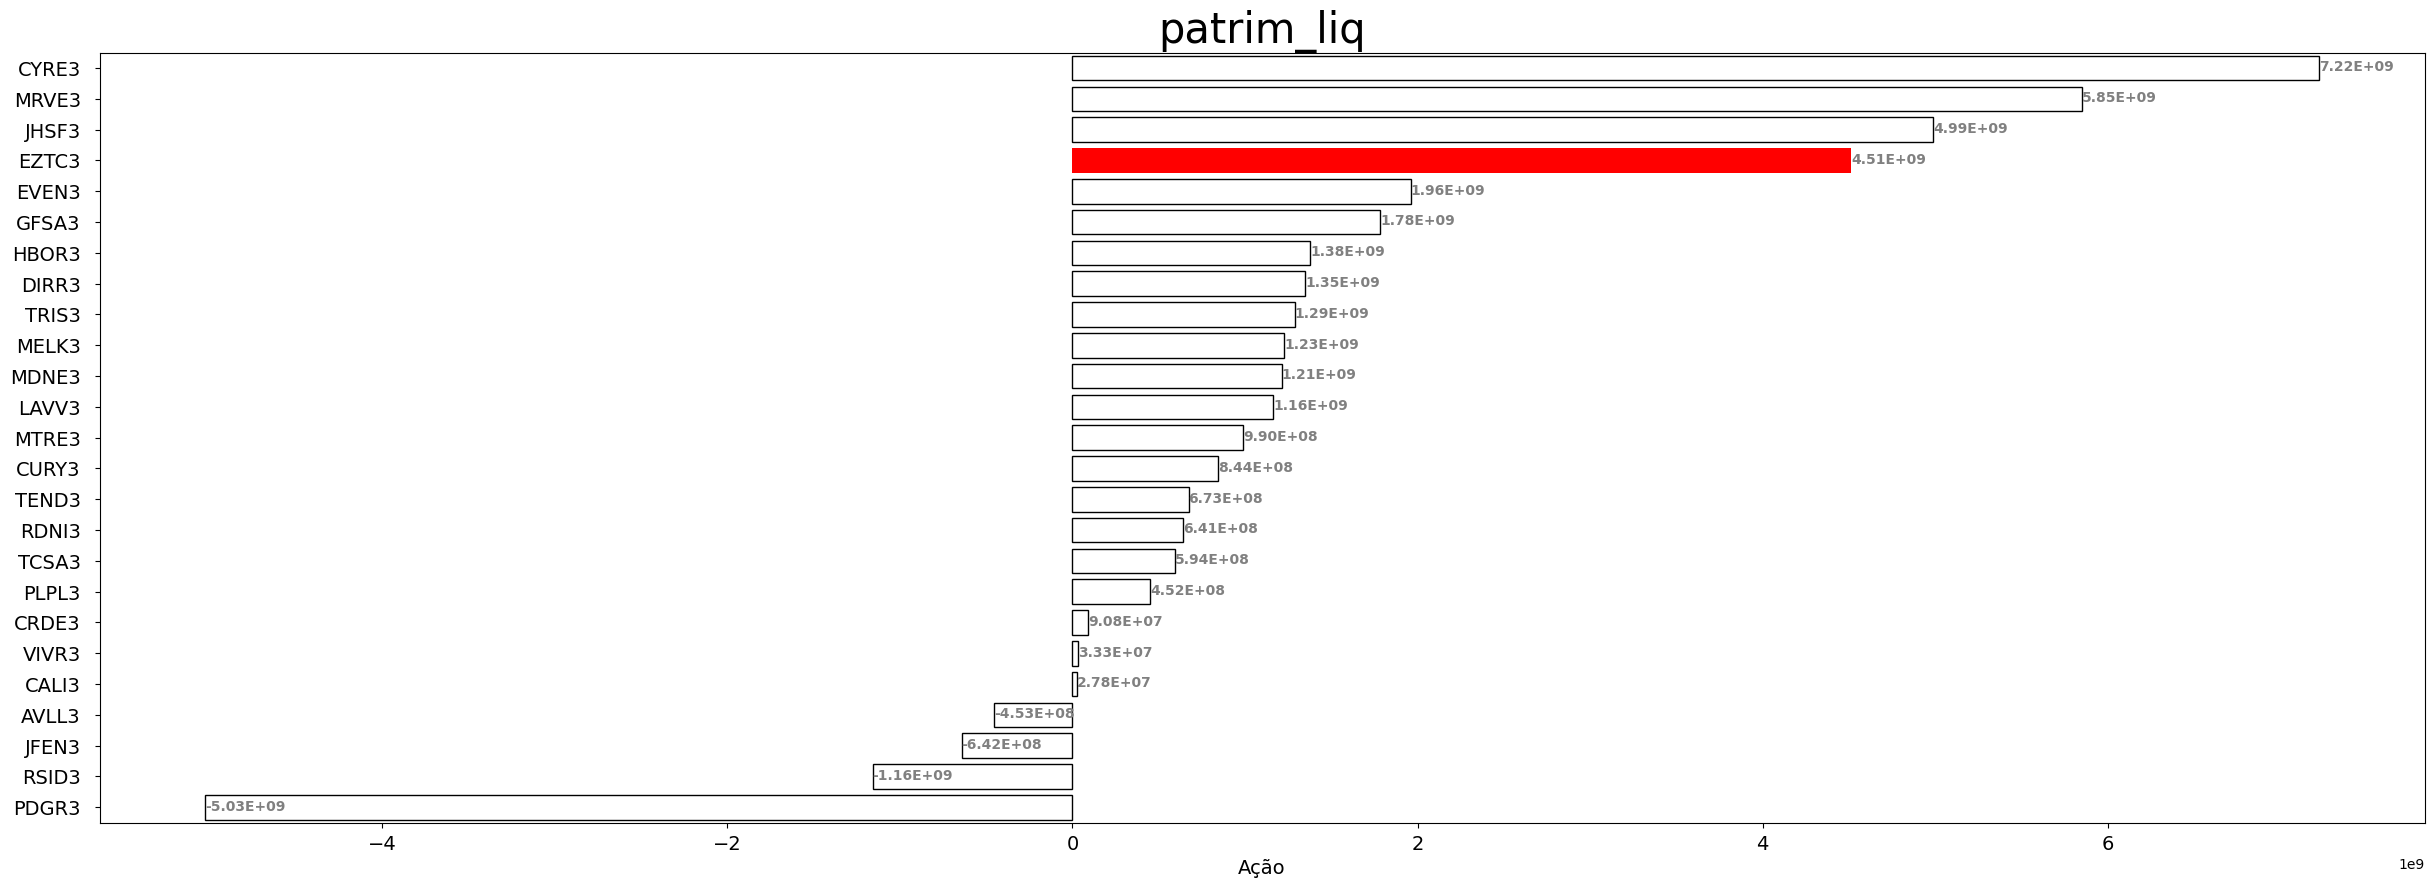

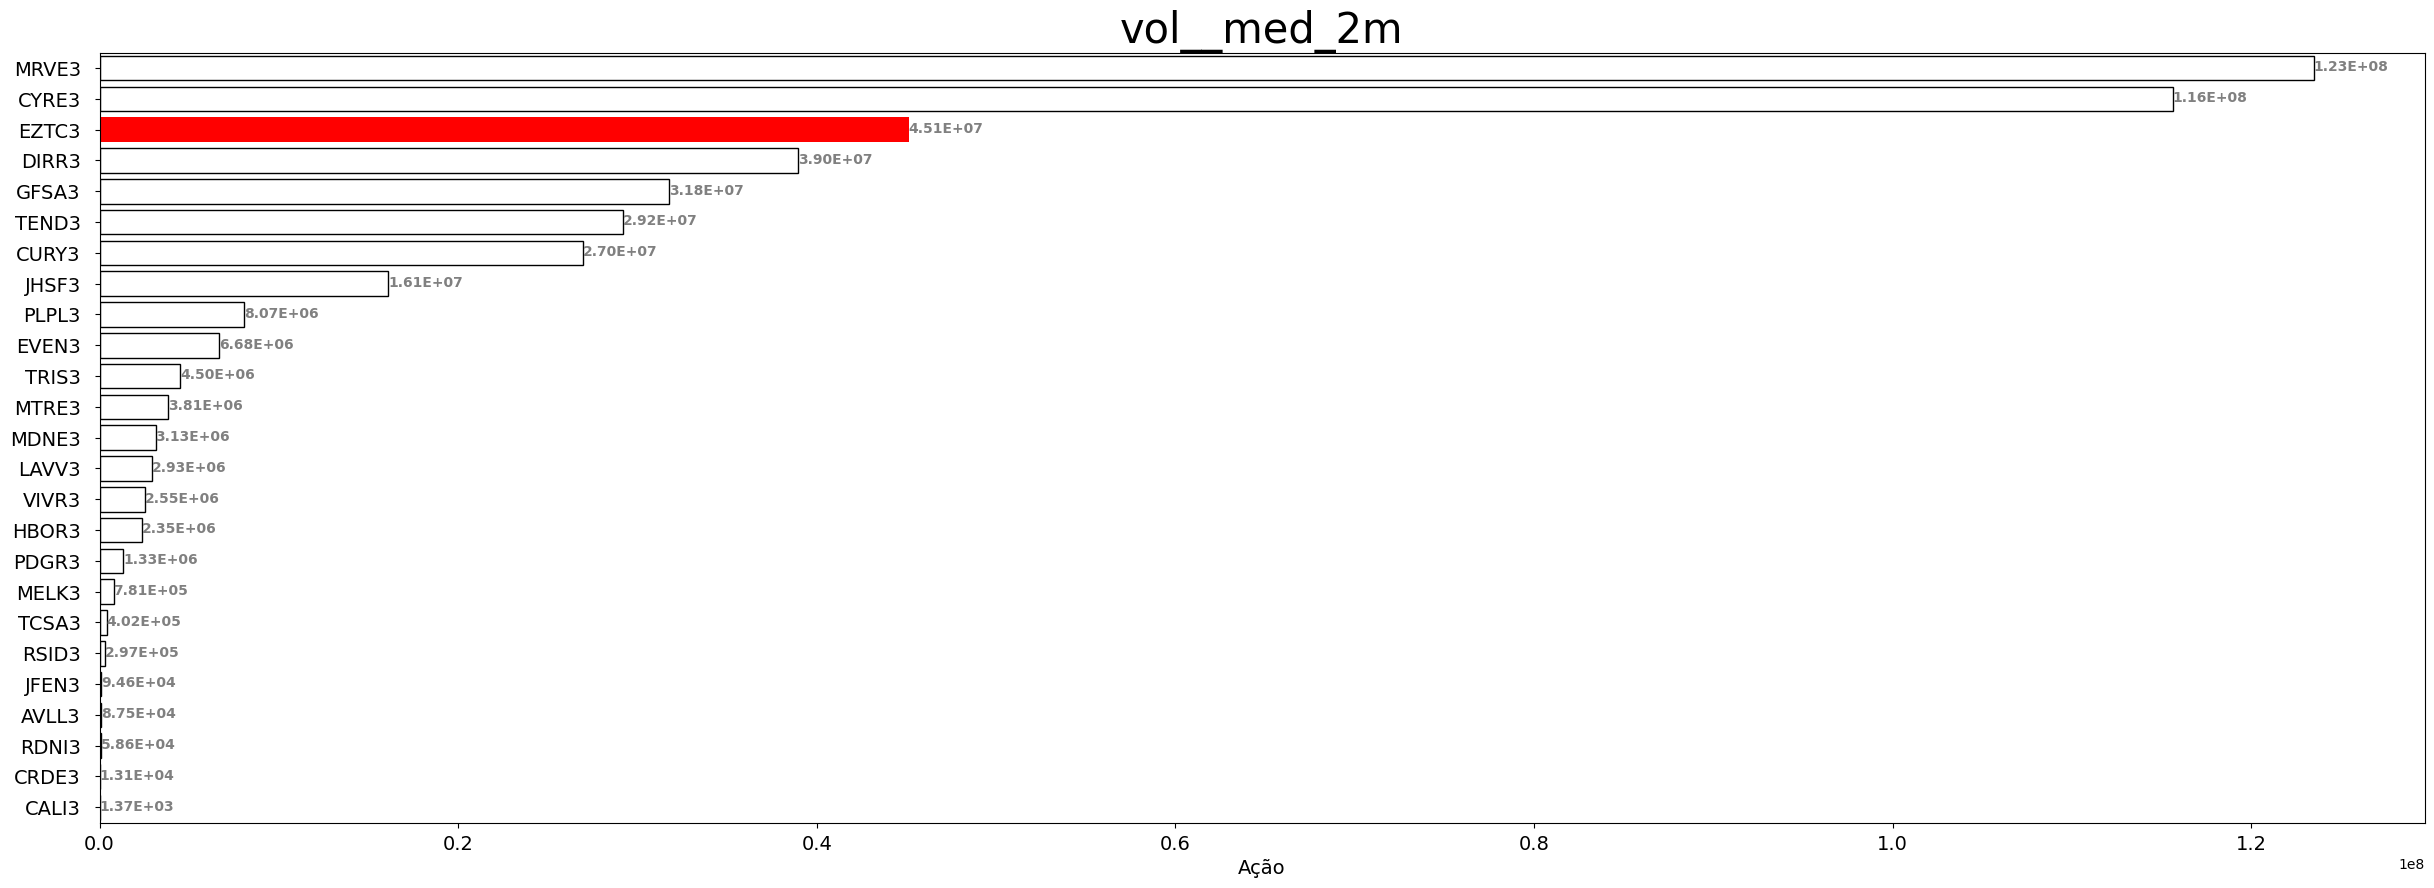

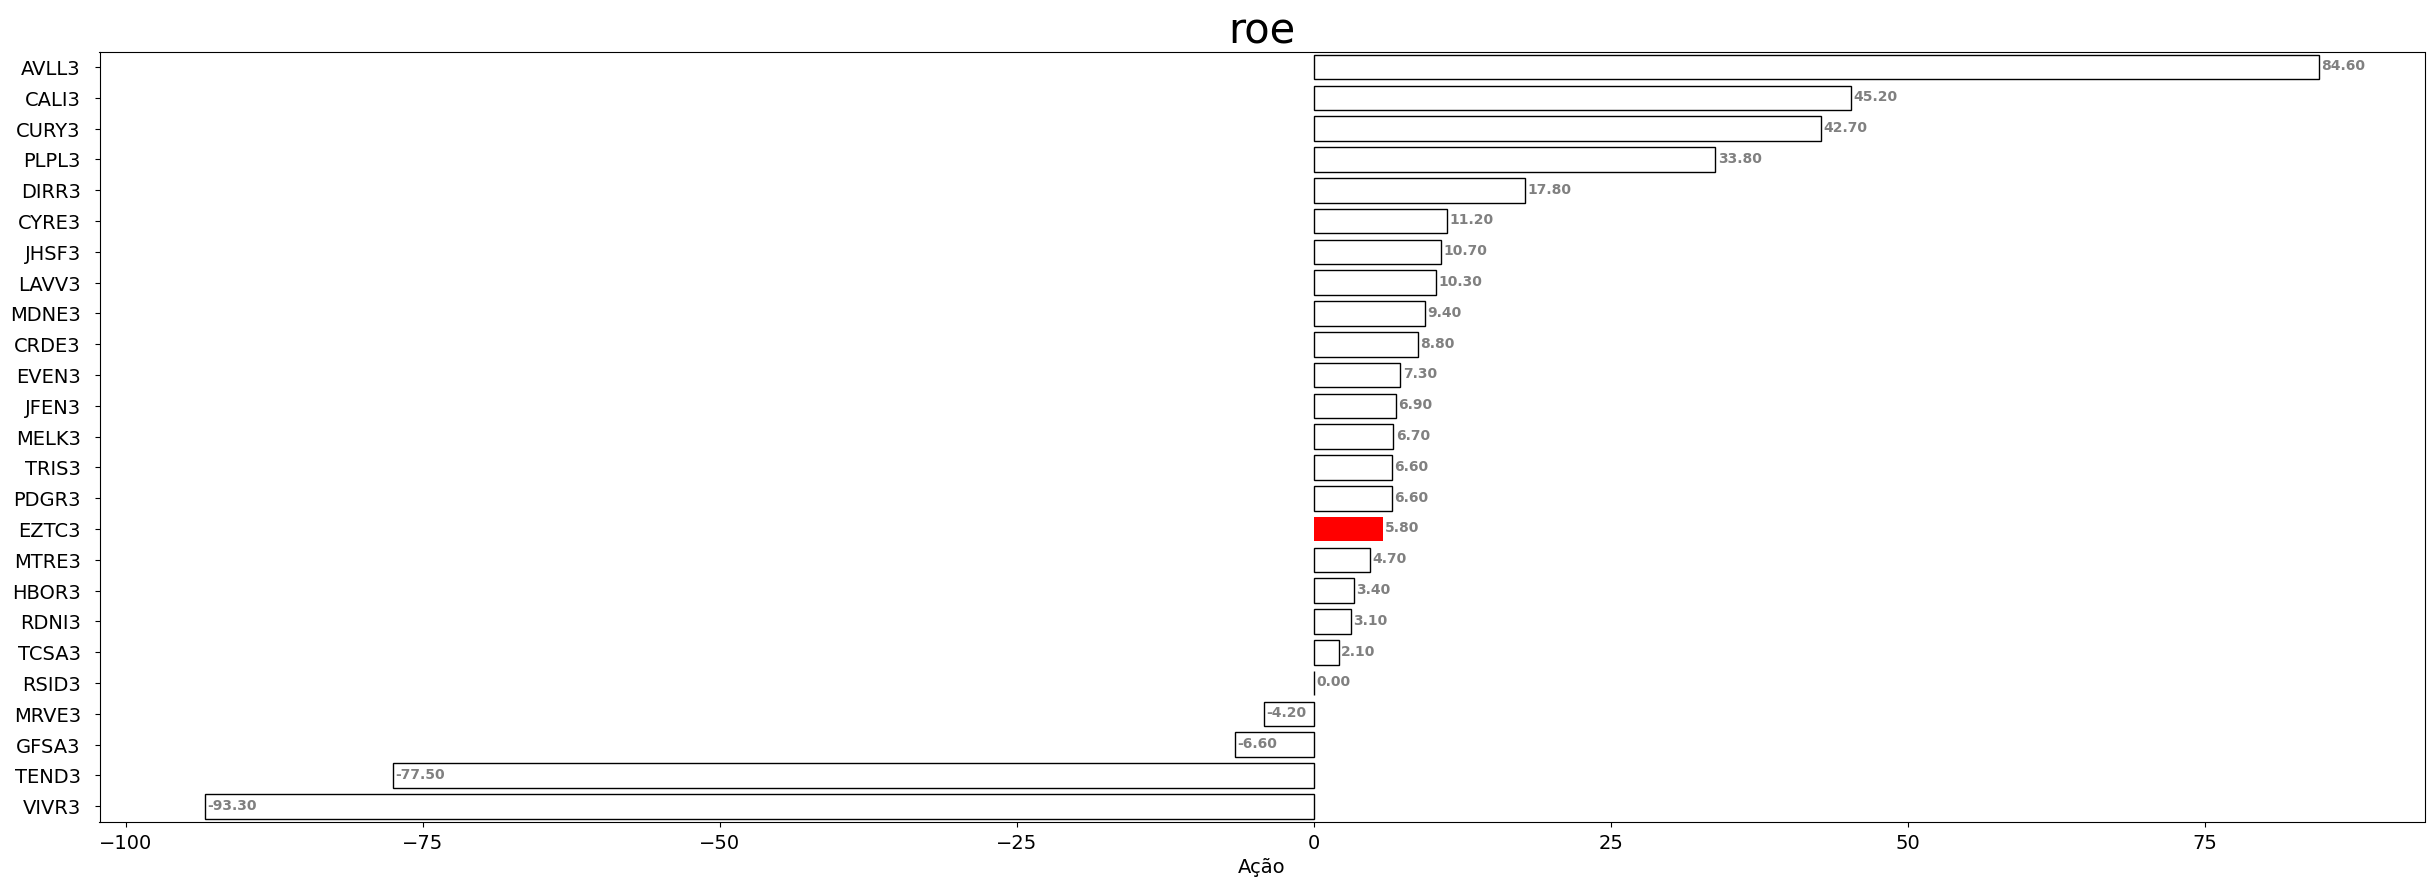

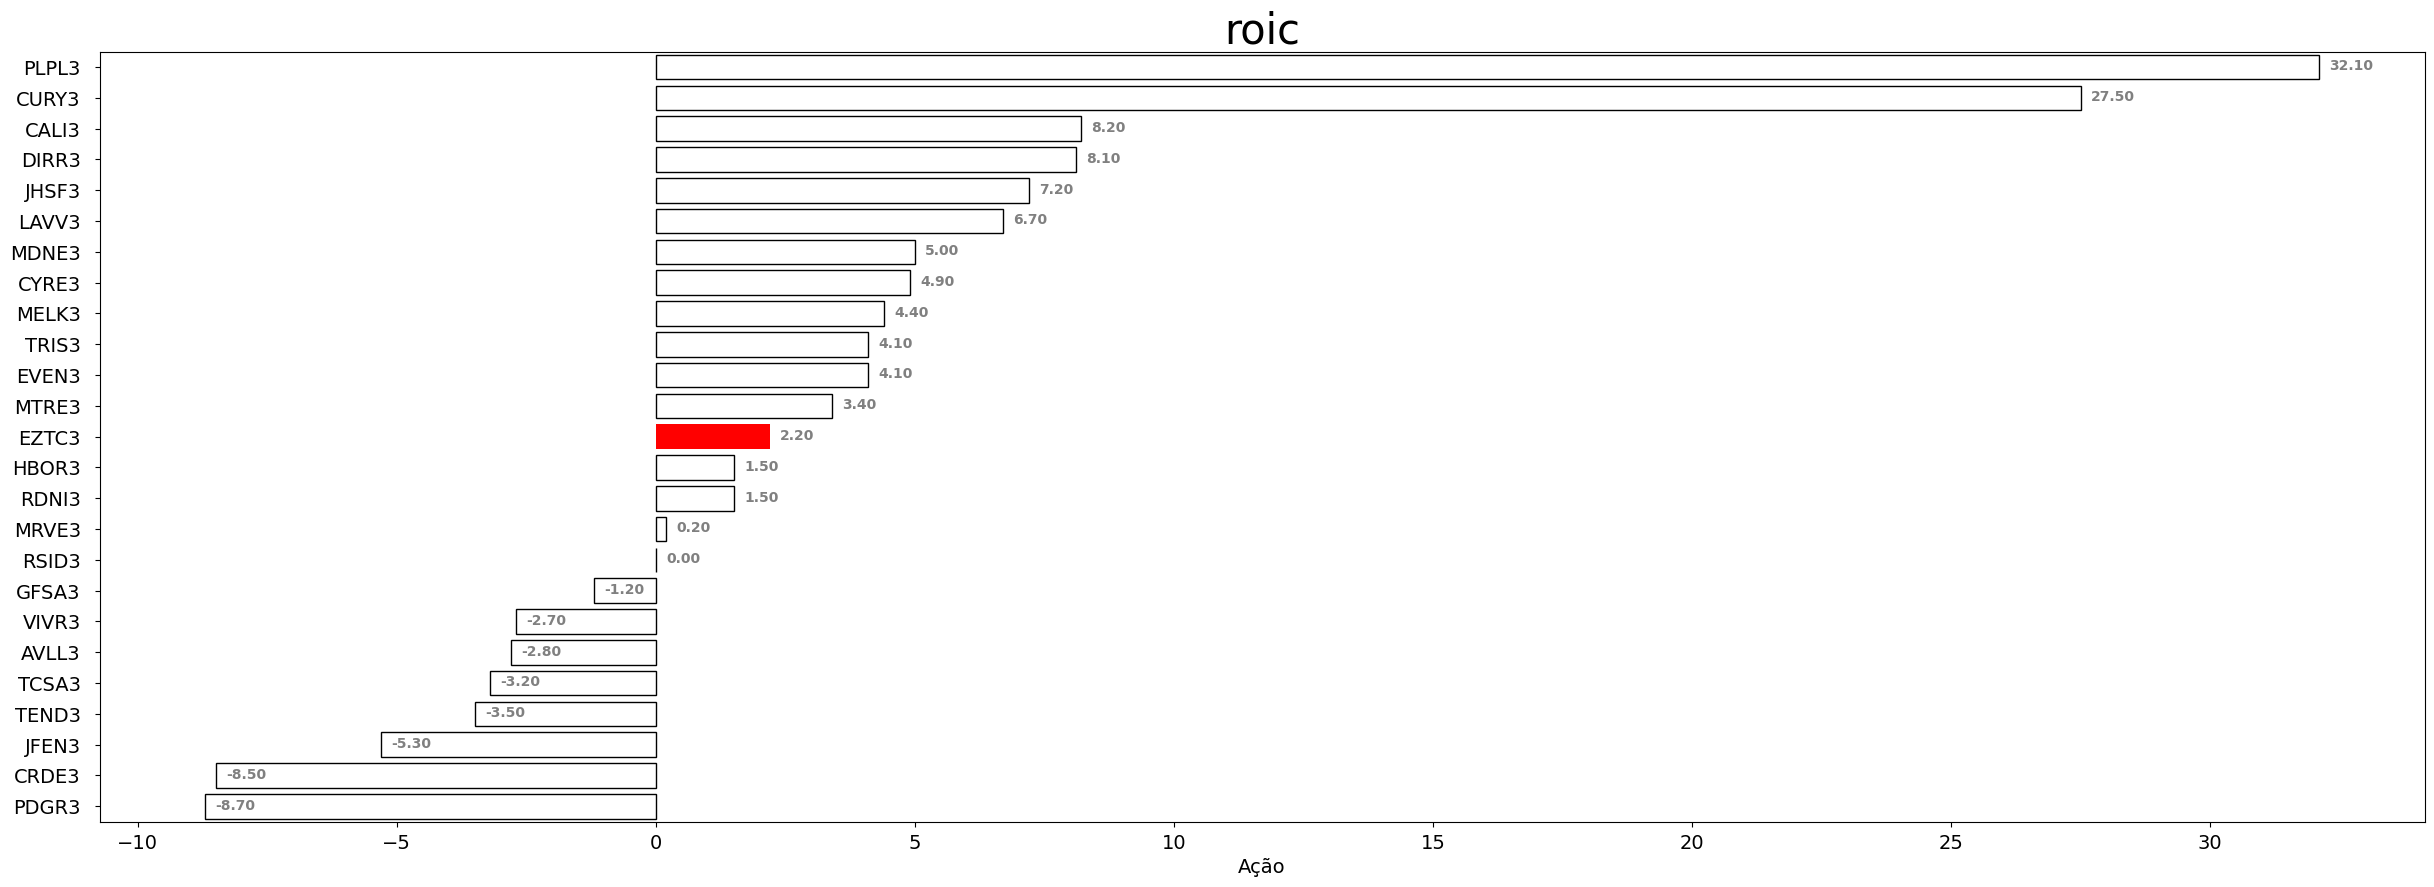

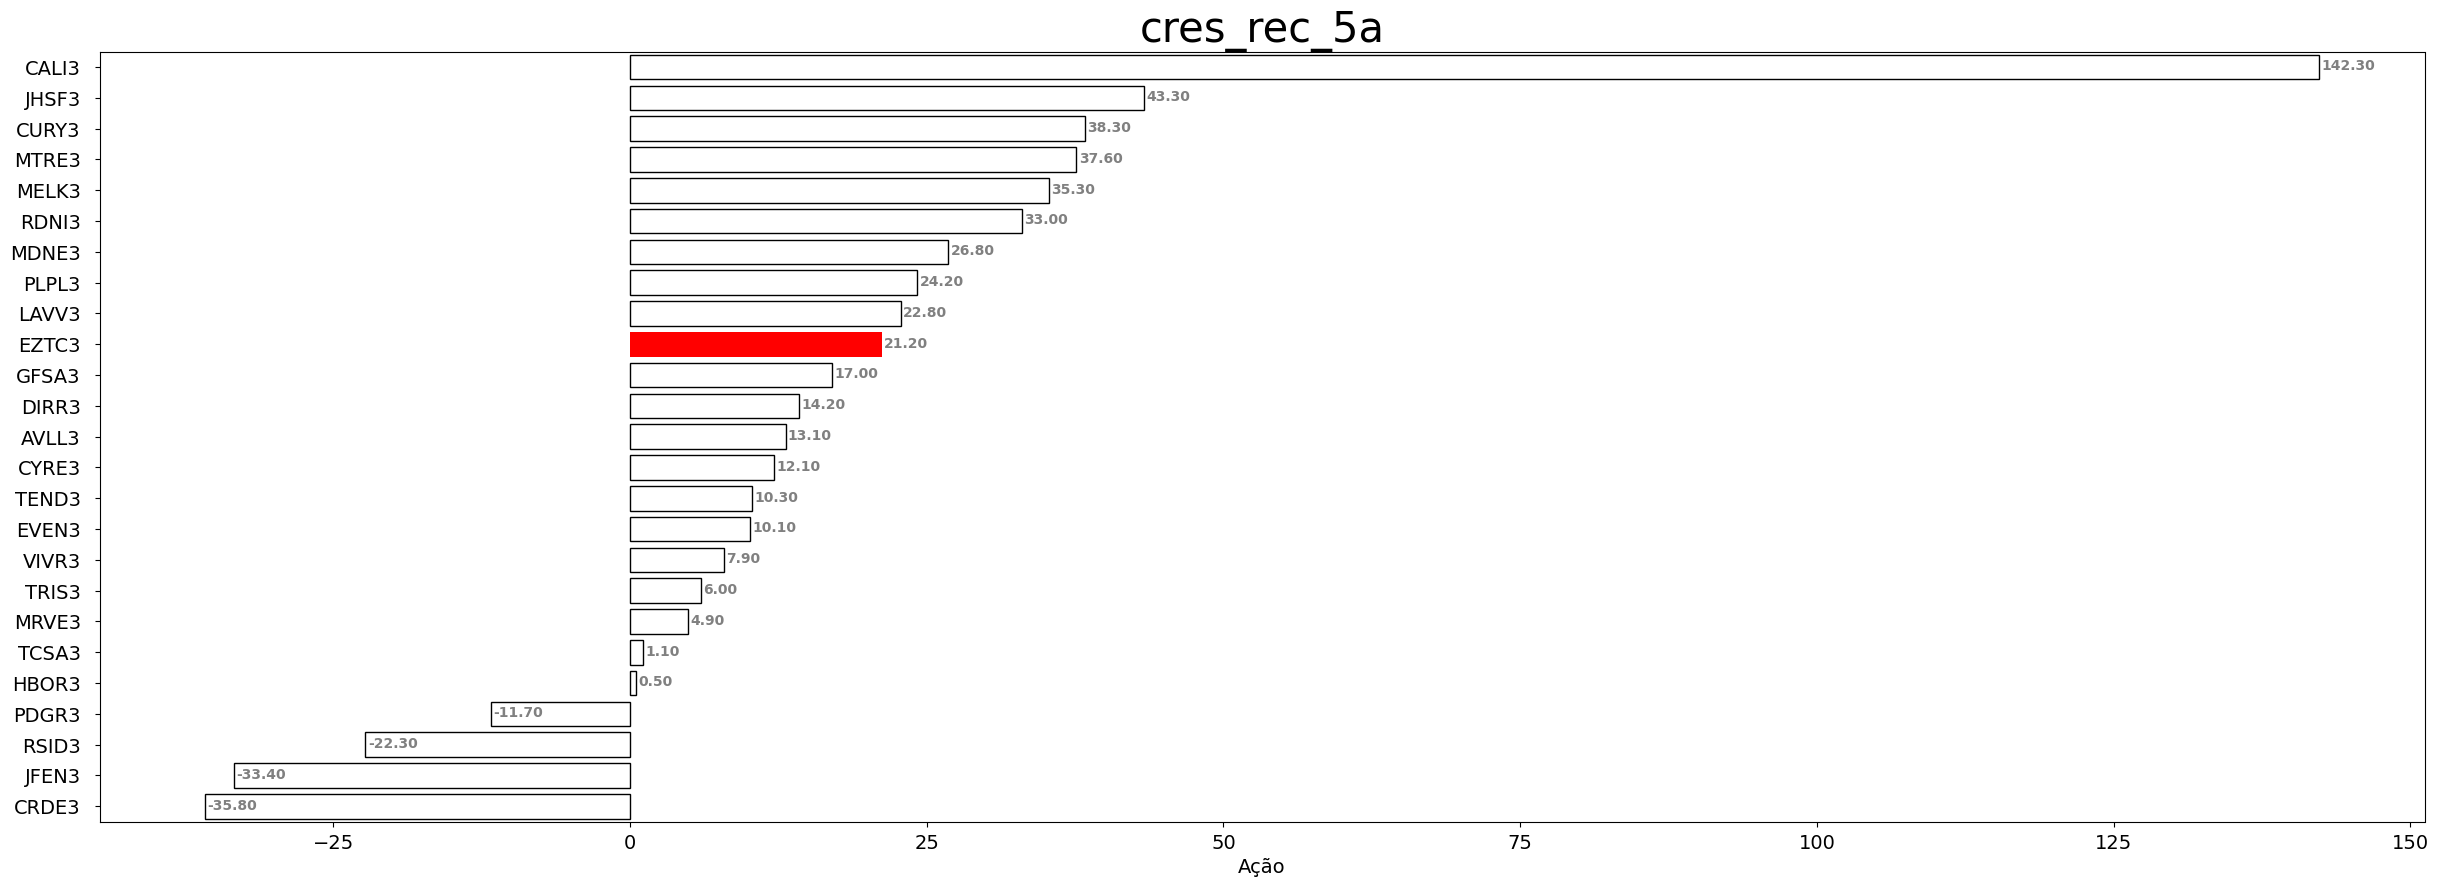

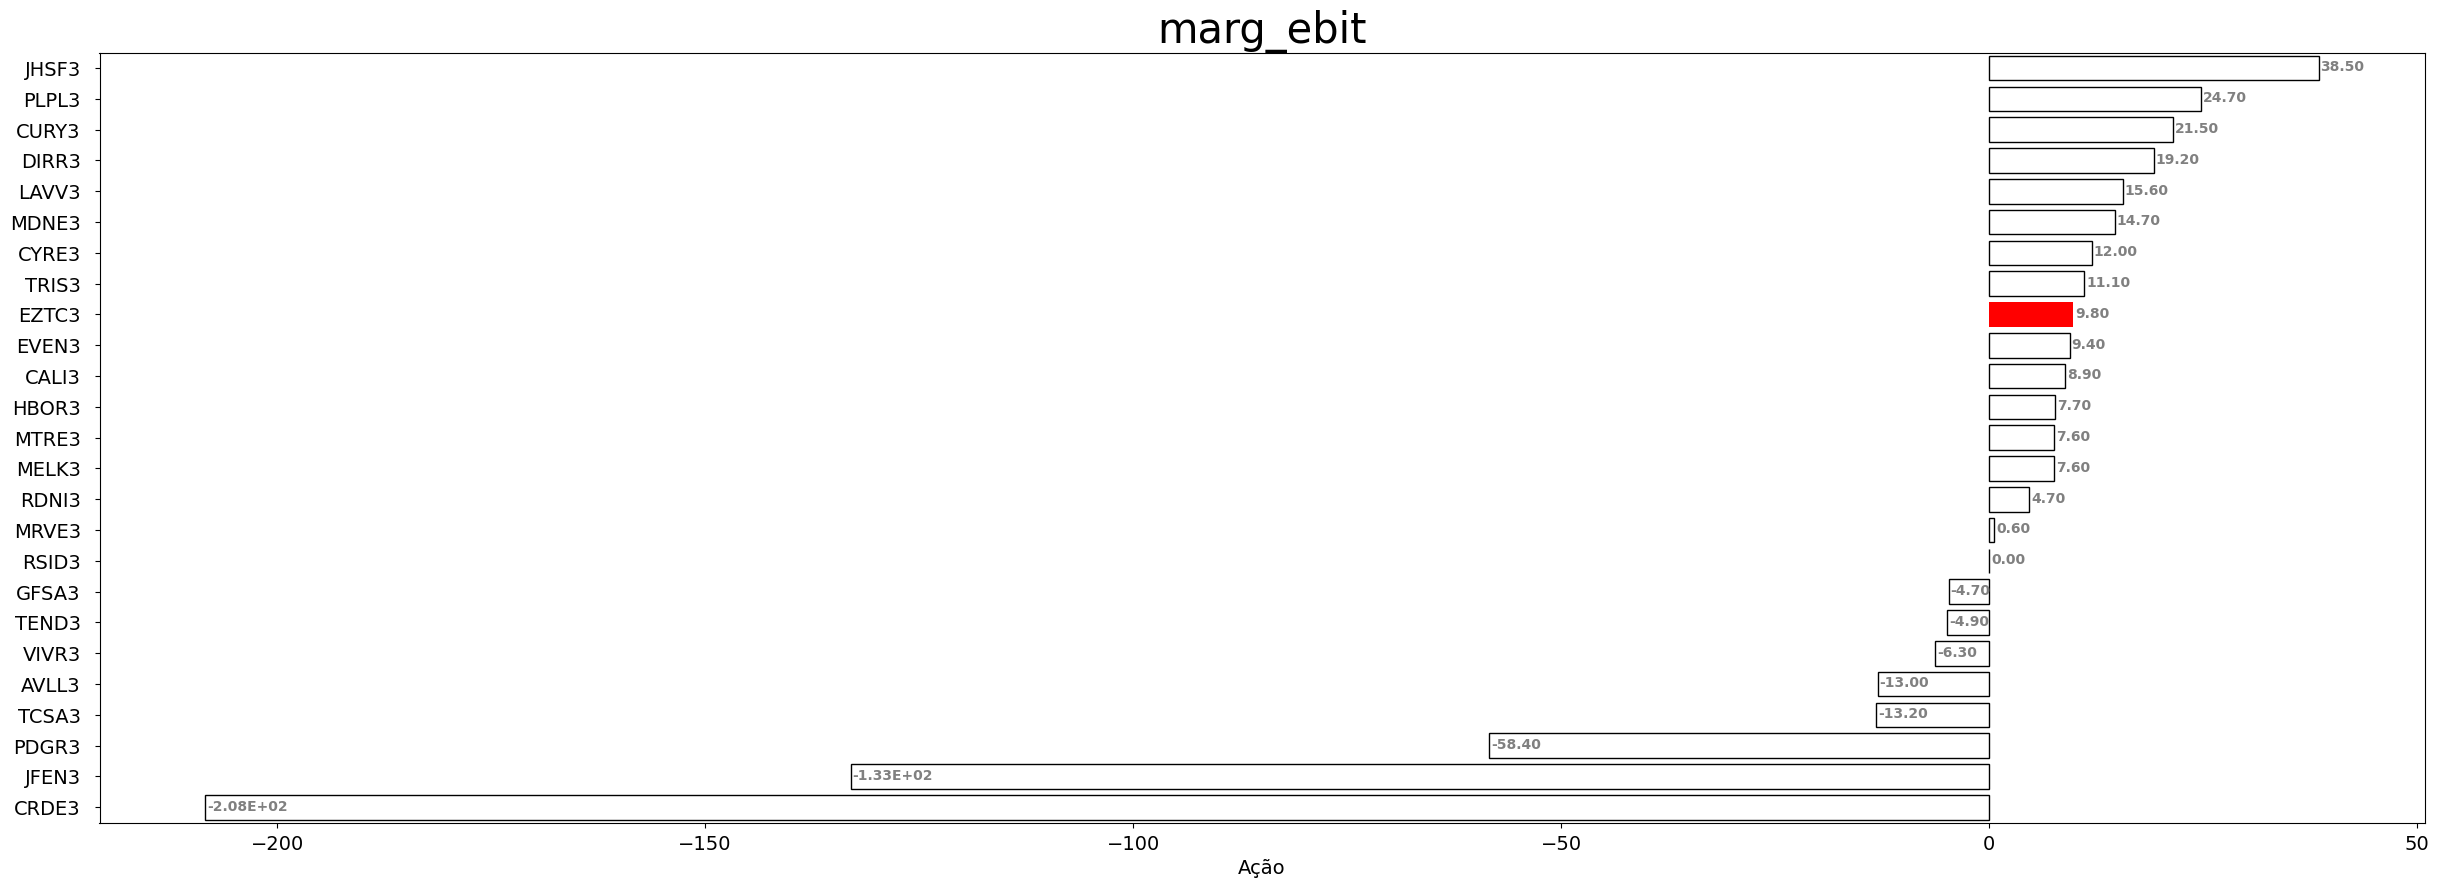

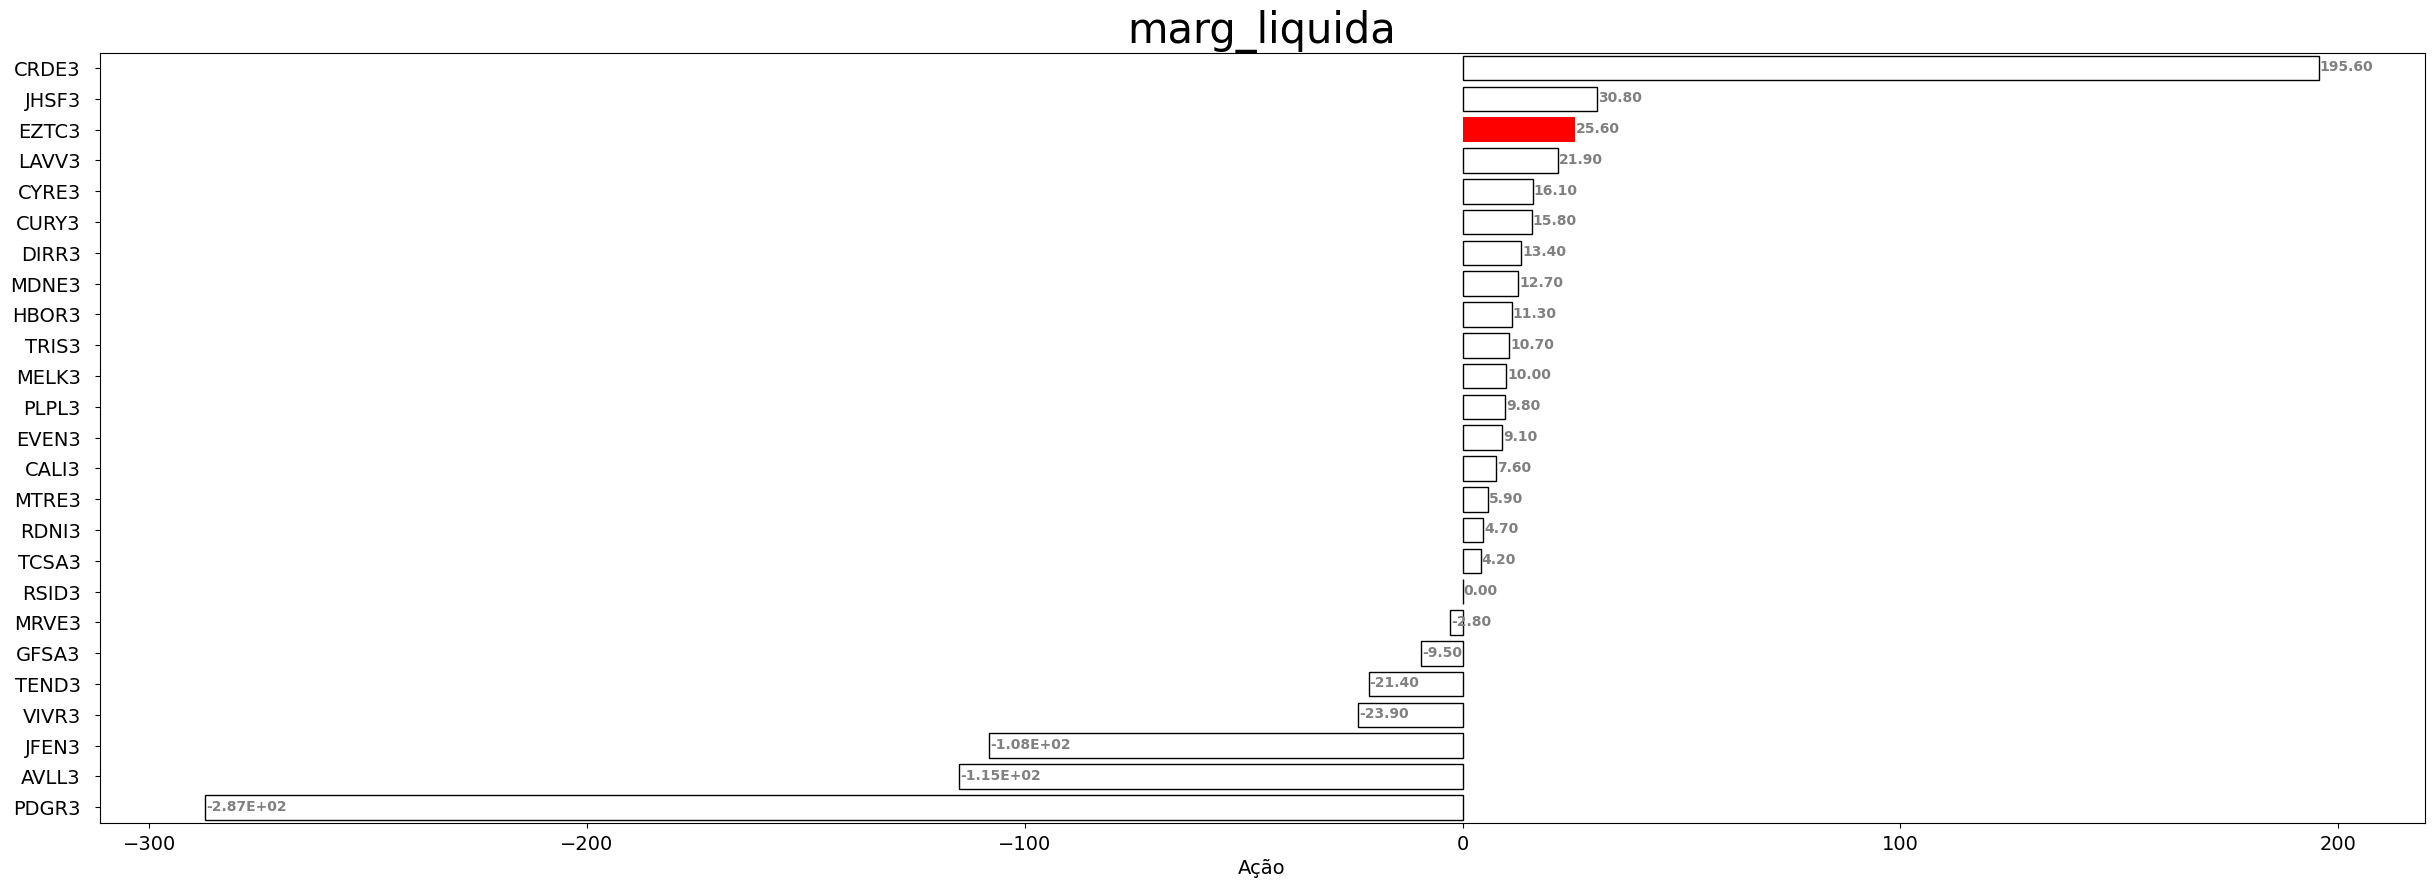

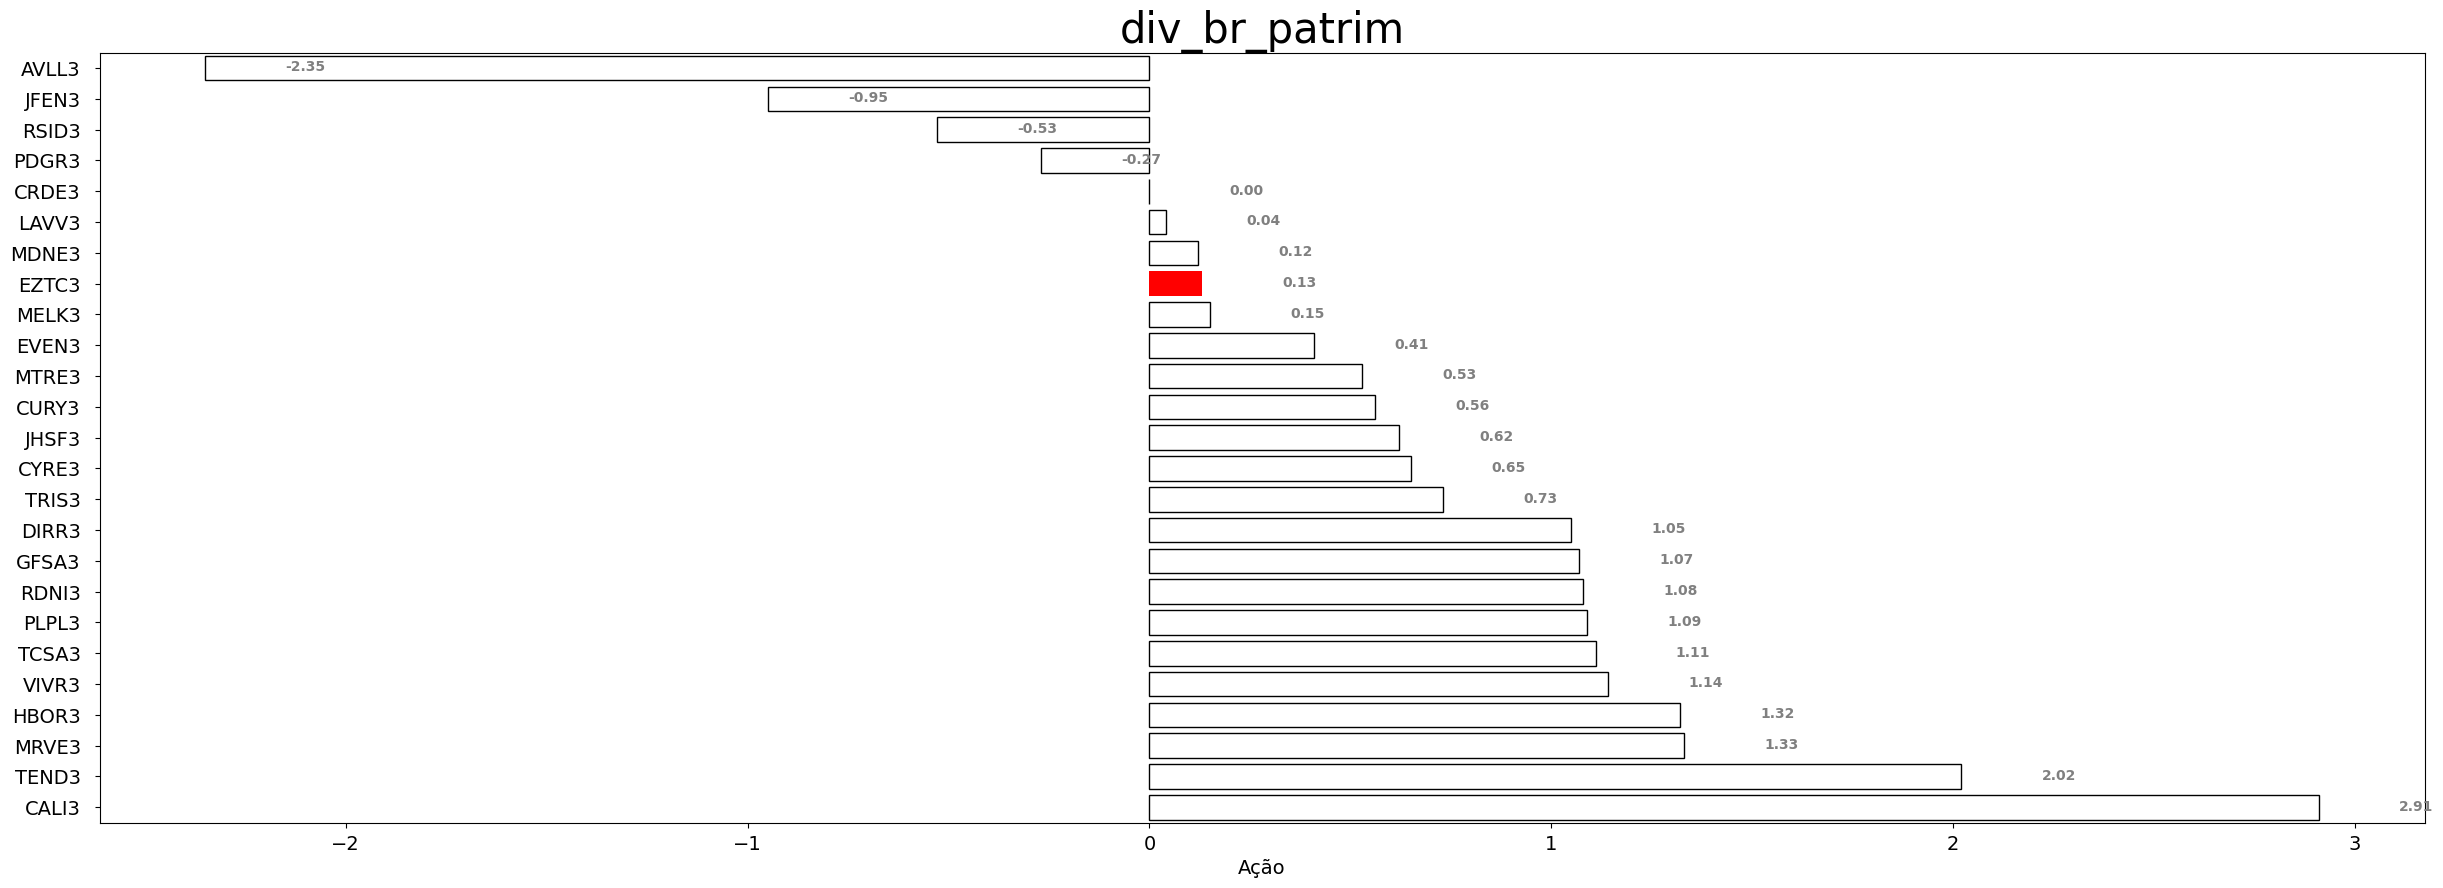

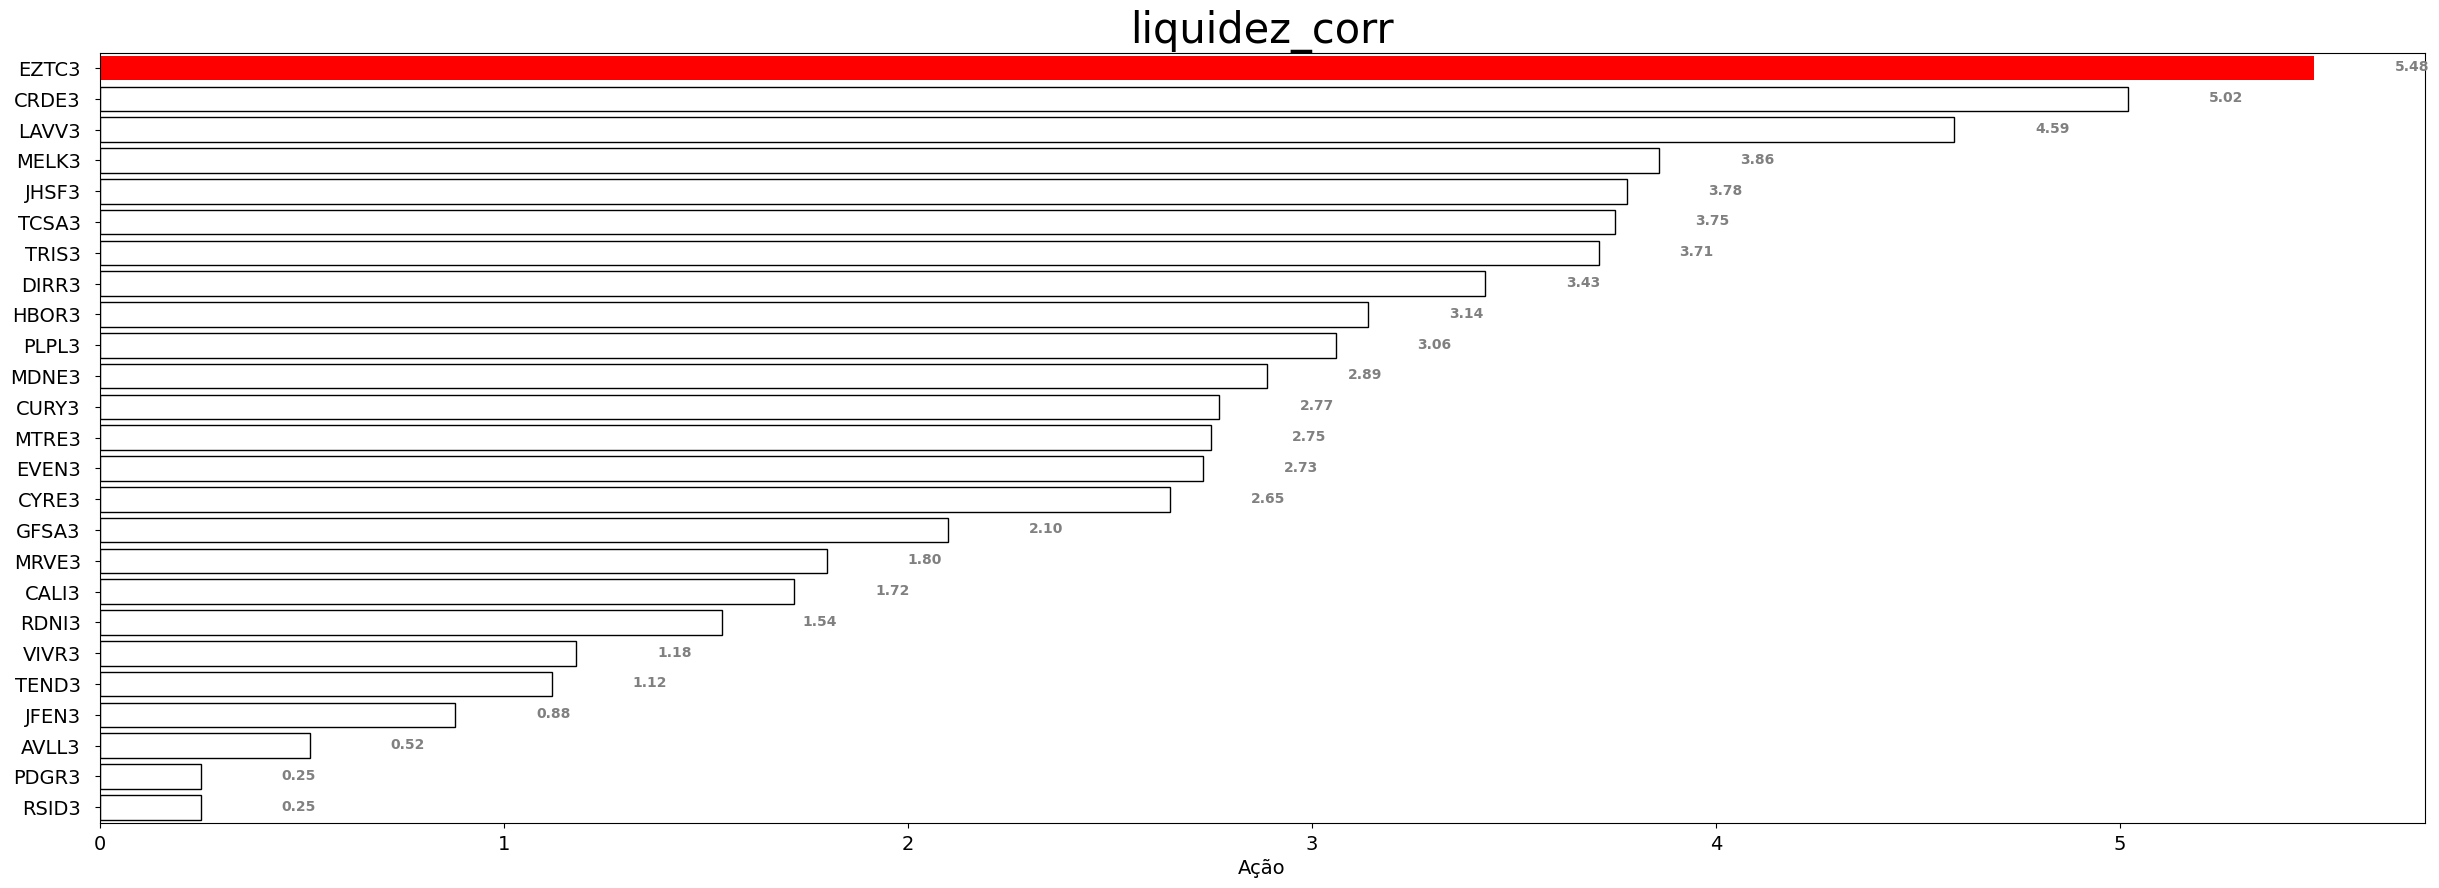

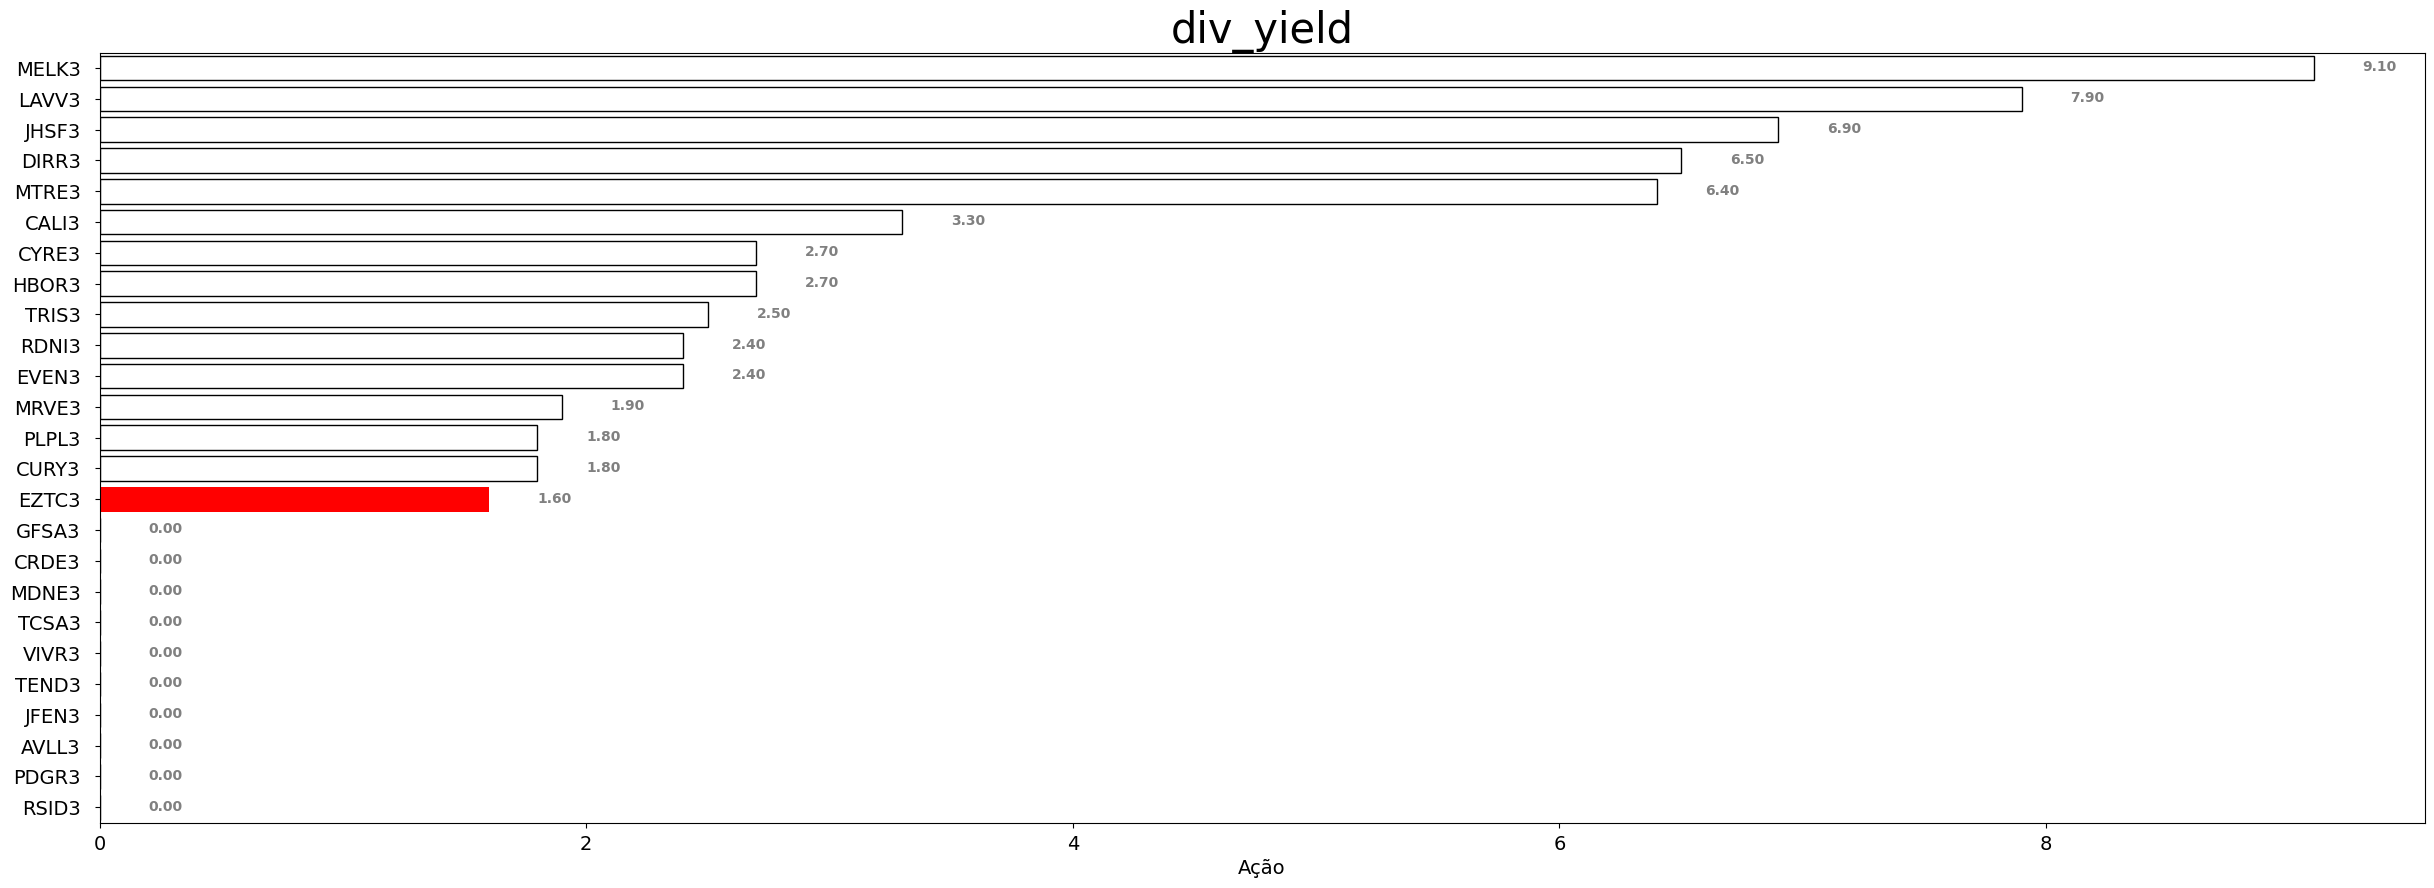

In [101]:

for indicador, ordenacao in multiplo_ordenacao.items():

  if tabelao[indicador].dtype == 'float64':
    tabelao.sort_values(by = indicador, ascending=ordenacao, inplace=True)

    #criando uma figure, axes, alterando tamanho
    fig, ax = plt.subplots(figsize=(30,10))
    #criando o gráfico de barras
    sns.barplot(x=indicador, y=tabelao.index, data=tabelao)

    #adicionando título
    ax.set_title(indicador, fontdict={'fontsize':30})
    #mudando nome e tamanho do label x
    ax.set_xlabel('Ação', fontdict={'fontsize':14})
    #mudando tamanho dos labels dos ticks
    ax.tick_params(labelsize=14)


    # #Colocando a quantidade em cada barra
    for i in ax.patches:
      s = str(round((i.get_width()), 2))
      if len(str(i.get_width())) > 5:
        s=f"{i.get_width():.2E}"
      else:
        s=f"{i.get_width():,.2f}"

      ax.text(i.get_width()+0.2, i.get_y()+0.5,
             s,
             fontsize = 10, fontweight ='bold',
             color ='grey')

    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 5)
    ax.yaxis.set_tick_params(pad = 10)

    # destacando a barra da ação desejada
    for ticks in ax.yaxis.get_major_ticks():
      if ticks.label1.get_text() not in codigo_acao_pesquisada:
          # for all other labels
          ax.patches[tabelao.index.get_indexer([ticks.label1.get_text()])[0]].set_facecolor('w')
          ax.patches[tabelao.index.get_indexer([ticks.label1.get_text()])[0]].set_edgecolor('black')
          # ticks.label1.set_visible(False)
      else:
          # for the desired label
          ax.patches[tabelao.index.get_indexer([ticks.label1.get_text()])[0]].set_facecolor('r')

    plt.savefig('/content/' + indicador + '.png')